In [ ]:
#@title Loading Functions

import base64
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import numpy as np
from scipy.integrate import odeint


# define TMA_PMMA model
class TMA_PMMA(object):
    """
    C + B -> S
    """
    
    def __init__(self, params):
        self.l = params['l'] * 2
        self.df = params['df']
        self.sc = params['sc']
        self.pc = params['pc']
        self.hd = params['hd']
        self.k = params['k']
    
    def fpde(self, state, t):
        # obtain state information
        C = state[:self.xlim]
        S = state[self.xlim:(2*self.xlim)]
        B = state[(2*self.xlim):(3*self.xlim)]
        # compute boundary condition
        bdC = self.sc if (t <= self.st) else max(0, self.sc * (1-(t-self.st)/60))
        # compute time derivative
        fluxC = np.diff(np.concatenate(([bdC],C,[bdC]))) / np.concatenate(([self.dx/2],np.repeat(self.dx,self.xlim-1),[self.dx/2]))
        dCdt = self.df * np.exp(-self.hd * S) * np.diff(fluxC)/self.dx - self.k * C * B
        dSdt = self.k * C * B
        dBdt = -self.k * C * B
        return np.concatenate((dCdt,dSdt,dBdt))

    def init_states(self, xlim = 1000):
        self.xlim = xlim
        self.dx = self.l / (self.xlim + 1)
        C = np.zeros(xlim)
        S = np.zeros(xlim)
        B = np.repeat(self.pc, xlim)
        return np.concatenate((C,S,B))

    def init_times(self, timepoints):
        # timepoints = (sorption_time (st), desorption_time (dt))
        self.st, self.dt = timepoints
        sorption_times = np.linspace(0, min(self.st,5000), 2001) # 2.5 seconds interval for first 5000 seconds
        if (self.st > 5025):
            steps = (self.st-5000-1)//25 # 25 seconds interval after 5000 seconds
            sorption_times = np.concatenate((sorption_times, np.linspace(5025,5025+(steps-1)*25,steps)))
        desorption_times = np.linspace(0, min(self.dt,5000), 2001) # 2.5 seconds interval for first 5000 seconds
        if (self.dt > 5000):
            steps = (self.dt-5000-1)//25 # 25 seconds interval after 5000 seconds
            desorption_times = np.concatenate((desorption_times, np.linspace(5025,5025+(steps-1)*25,steps), np.array([self.dt])))
        return np.concatenate((sorption_times, self.st+desorption_times))
    
    def solve(self, timepoints, xlim = 1000, rtol = 1.49012e-8, atol = 1.49012e-8):
        self.times = self.init_times(timepoints)
        s0 = self.init_states(xlim)
        states = odeint(self.fpde, s0, self.times, rtol=rtol, atol=atol)
        self.C = states[:,:self.xlim] * self.l * (72 * 1e9) / 2
        self.S = states[:,self.xlim:(2*self.xlim)] * self.l * (72 * 1e9) / 2
        self.B = states[:,(2*self.xlim):(3*self.xlim)] * self.l * (72 * 1e9) / 2

    def mass_uptake_over_time(self, csv=True, visualization=True, return_value=False):
        C, S, B = np.mean(self.C,1), np.mean(self.S,1), np.mean(self.B,1)
        if (csv):
            csv = 'times,C,S,B\n' + '\n'.join(['%.18e,%.18e,%.18e,%.18e' %(self.times[i],C[i],S[i],B[i]) for i in range(self.times.size)])
            html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
            html = html.format(payload=base64.b64encode(csv.encode()).decode(),title="Download CSV File",filename="mass_uptake.csv")
            display(HTML(html))
        if (visualization):
            fig = plt.figure(figsize=(8,6), facecolor='w')
            ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
            ax.plot(np.sqrt(self.times), C+S, lw=1)
            ax.set_xlabel('time^0.5 (s^0.5)')
            ax.set_ylabel('Mass/Area (ng/cm^2)')
            plt.show()
        if (return_value):
            return (C,S,B)

    def depth_profile(self, component, phase, timepoints, csv=True, visualization=True, return_value=False):
        tps = np.array(timepoints)
        if (phase == "desorption"): 
            tps = tps + self.st
        timeidx = np.argmin(np.abs(tps[:,None] - self.times), axis=1)
        if (component == 'C'):
            val = self.C[timeidx,:]
        elif (component == 'B'):
            val = self.B[timeidx,:]
        elif (component == 'S'):
            val = self.S[timeidx,:]
        else:
            raiseRuntimeError("Invalid component %s" %(component))
        if (csv):
            csv_header = 'times,' + ','.join([str(i+1) for i in range(self.xlim)]) + '\n'
            csv_text = '\n'.join(['%.18e,' % timepoints[i] + ','.join('%18e' % val[i,j] for j in range(self.xlim)) for i in range(len(timepoints))])
            csv = csv_header + csv_text
            html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
            html = html.format(payload=base64.b64encode(csv.encode()).decode(),title="Download CSV File",filename="depth_profile.csv")
            display(HTML(html))
        if (visualization):
            fig = plt.figure(figsize=(8,6), facecolor='w')
            ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
            cmap=plt.get_cmap("jet")
            for i in range(len(timepoints)):
                color = cmap(i/len(timepoints))
                ax.plot(1+np.arange(self.xlim), val[i,:], color=color, label=timepoints[i])
            ax.set_xlabel('space discretization')
            ax.set_ylabel('Mass/Area (ng/cm^2)')
            ax.legend()
            plt.ylim([-0.05*np.max(val),1.10*np.max(val)])
            plt.show()
        if (return_value):
            return val

VPI process is described as

In [ ]:
#@title Define Parameters

# please change only this part of the code
# define model parameters
l = 4.830e-5 # polymer thickness (cm)
df = 1.650e-10 # initial diffusivity (cm^2/s) 
sc = 4.436e-3 # surface concentraion (mol/cm^3)
pc = 5.656e-3 # polymer concentraion (mol/cm^3)
hd = 1150 # hindering factor (cm^3/mol)
k = 1 # reaction rate (cm^3/mol*s)
st = 62500 # sorption time length
dt = 62500 # desorption time length

In [ ]:
#@title Running Models

model_params = {'l':l, 'df':df, 'sc':sc, 'pc':pc, 'hd':hd, 'k':k}
model = TMA_PMMA(model_params)
model.solve((st,dt), xlim=1000, rtol=1e-3, atol=1e-3)

### Mass Uptake Over Time

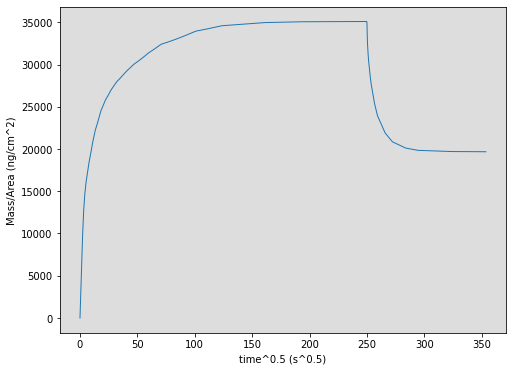

In [ ]:
model.mass_uptake_over_time(csv=True, visualization=True, return_value=False)

### Depth Profile

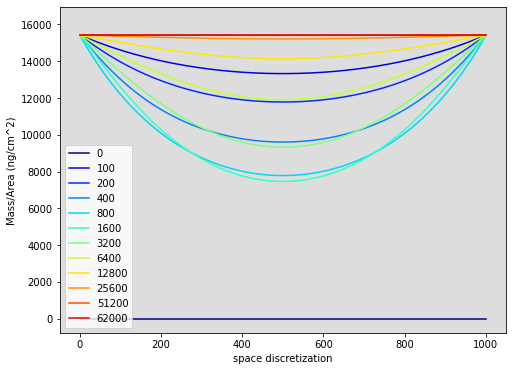

In [ ]:
component = 'C' # C/S/B
phase = 'sorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

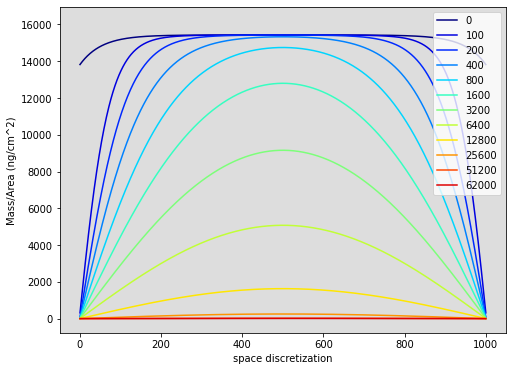

In [ ]:
component = 'C' # C/S/B
phase = 'desorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

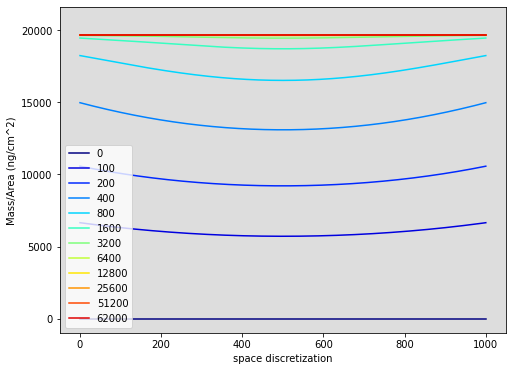

In [ ]:
component = 'S' # C/S/B
phase = 'sorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

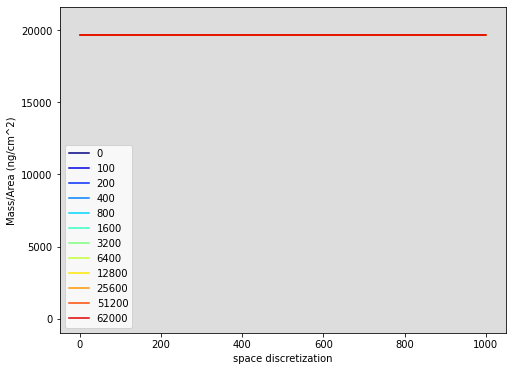

In [ ]:
component = 'S' # C/S/B
phase = 'desorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

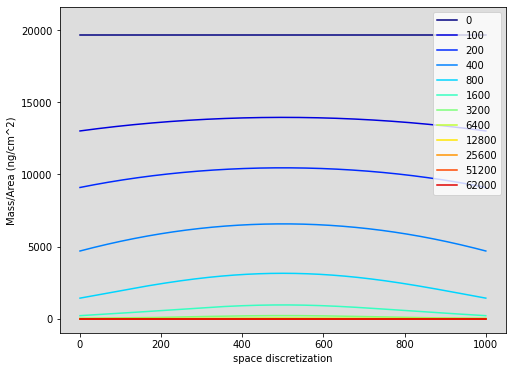

In [ ]:
component = 'B' # C/S/B
phase = 'sorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)